In [123]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.feature_selection import mutual_info_regression


In [124]:
import warnings
warnings.filterwarnings('ignore')

In [127]:
# Path to data and results
data_path = 'data_set/'
results_path = 'result/'

In [128]:
# Load data
train_data = pd.read_csv(data_path + 'train.csv')
test_data = pd.read_csv(data_path + 'test.csv')

In [129]:
def create_csv(y_test_pred_log, name):
    y_test_pred = np.expm1(y_test_pred_log)
    submission = pd.DataFrame({'id': test_data['id'], 'cost': y_test_pred})
    submission.to_csv(results_path + name + '.csv', index=False)

In [130]:
def get_rmsle_score(y_pred_log, y_val_log):
    y_pred = np.expm1(y_pred_log)
    y_val = np.expm1(y_val_log)
    print(mean_squared_log_error(y_val, y_pred, squared=False))

In [131]:
train_data.describe()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
count,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000
mean,180167.500000,6.337376,3.043881,2.456482,0.689390,2.203813,13.822071,0.568086,0.327797,18.972706,28180.333442,0.564839,0.277394,0.504807,0.504832,0.503191,99.614729
std,104020.187637,3.307980,0.784676,1.488992,1.214732,1.084293,4.614792,0.495343,0.469411,10.212912,5968.874074,0.495779,0.447713,0.499978,0.499977,0.499991,29.939435
min,0.000000,0.510000,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,20319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.790000
25%,90083.750000,3.720000,3.000000,1.000000,0.000000,1.000000,9.710000,0.000000,0.000000,10.000000,23593.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.320000
50%,180167.500000,5.780000,3.000000,2.000000,0.000000,2.000000,13.600000,1.000000,0.000000,20.000000,27694.000000,1.000000,0.000000,1.000000,1.000000,1.000000,98.810000
75%,270251.250000,8.400000,4.000000,4.000000,1.000000,3.000000,17.700000,1.000000,1.000000,28.000000,33858.000000,1.000000,1.000000,1.000000,1.000000,1.000000,126.620000
max,360335.000000,22.920000,6.000000,5.000000,5.000000,4.000000,21.900000,1.000000,1.000000,36.000000,39696.000000,1.000000,1.000000,1.000000,1.000000,1.000000,149.750000


In [132]:
train_data.isnull().sum()

id                            0
store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coffee_bar                    0
video_store                   0
salad_bar                     0
prepared_food                 0
florist                       0
cost                          0
dtype: int64

In [133]:
test_data.isnull().sum()

id                            0
store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coffee_bar                    0
video_store                   0
salad_bar                     0
prepared_food                 0
florist                       0
dtype: int64

No missing values exist

<AxesSubplot:>

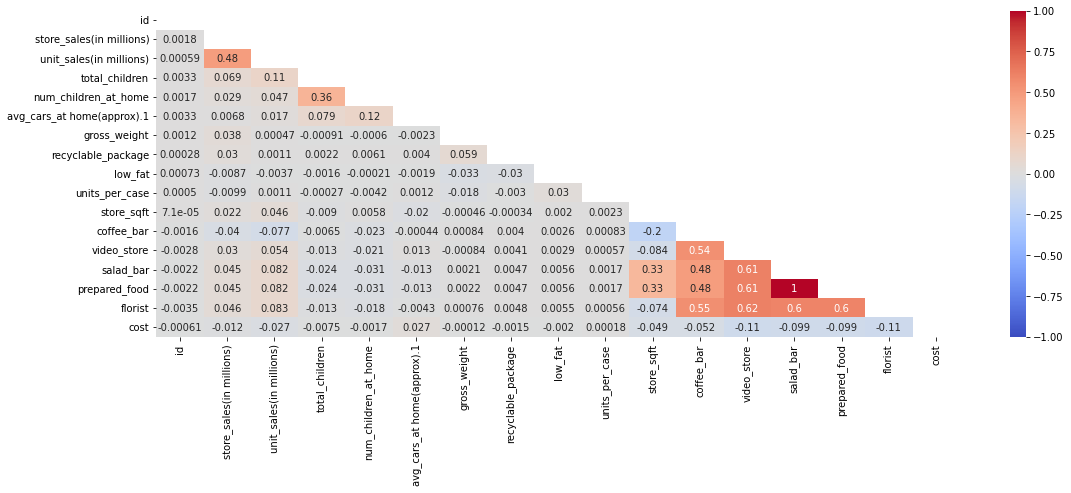

In [134]:
# Correlation matrix
correlation_matrix = train_data.corr()
plt.figure(figsize=(18, 6))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, mask=mask,
            cmap='coolwarm', vmin=-1, vmax=1)

`salad_bar` and `prepared_food` has value 1 in correlation matrix, so we will drop one of them.

In [135]:
# Drop columns
X = train_data.drop(['id', 'prepared_food', 'cost',], axis=1)
y = train_data['cost']
X_test = test_data.drop(['id', 'prepared_food'], axis=1)


<AxesSubplot:>

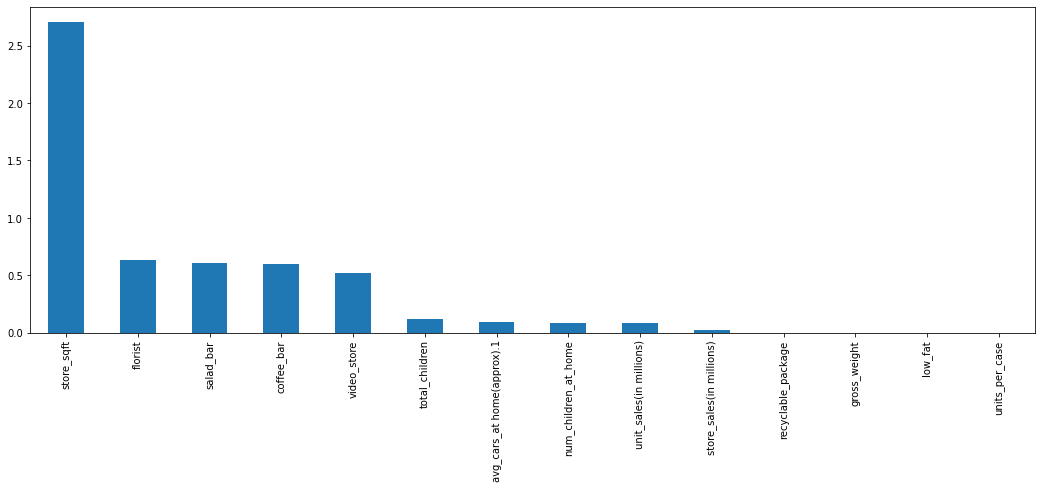

In [136]:
mi = pd.Series(mutual_info_regression(X, y), index=X.columns)
mi = mi.sort_values(ascending=False)
mi.plot.bar(figsize=(18, 6))

`gross_weight`, `units_per_case`, `low_fat`, and `recyclable_package` has least correlation with `cost` so we will drop them.

In [137]:
# Drop columns
X = X.drop(['gross_weight', 'units_per_case', 'low_fat', 'recyclable_package'], axis=1)
X_test = X_test.drop(['gross_weight', 'units_per_case', 'low_fat', 'recyclable_package'], axis=1)

In [138]:
X['store_sqft'] = X['store_sqft'].astype('category')
X_test['store_sqft'] = X_test['store_sqft'].astype('category')

In [139]:
y_log = np.log1p(y)

In [140]:
# Feature Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

In [141]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_log, test_size=0.2, random_state=42)

# `XGBRegressor` model

In [142]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    gpu_id=0,
    subsample=0.8,
    n_estimators=600,
    min_child_weight=2,
    max_depth=9,
    learning_rate=0.01,
    gaxgb_modelmma=0.1,
    colsample_bytree=1
)

In [143]:
abs(cross_val_score(xgb_model, X_scaled, y_log,
    scoring='neg_root_mean_squared_error', cv=5, verbose=3).mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-0.295) total time=  28.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.1s remaining:    0.0s


[CV] END ............................... score: (test=-0.296) total time=  27.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   55.5s remaining:    0.0s


[CV] END ............................... score: (test=-0.296) total time=  27.0s
[CV] END ............................... score: (test=-0.297) total time=  26.3s
[CV] END ............................... score: (test=-0.296) total time=  26.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min finished


0.2958134197870238

In [144]:
# predict and generate submission file for xgb
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_val)
get_rmsle_score(y_pred, y_val)

y_test_pred = xgb_model.predict(X_test_scaled)
create_csv(y_test_pred, 'xgb')

0.2959044134661551


# `CatboostRegressor` model

In [145]:
params = {
    'subsample': 0.9,
    'min_child_samples': 1,
    'learning_rate': 0.1,
    'l2_leaf_reg': 3,
    'iterations': 200,
    'depth': 10,
    'colsample_bylevel': 1.0,
    'verbose': 0,
}

catboost_model = CatBoostRegressor(
    **params
)

In [146]:
abs(cross_val_score(catboost_model, X_scaled, y_log,
    scoring='neg_root_mean_squared_error', cv=5, verbose=3).mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-0.295) total time=  11.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


[CV] END ............................... score: (test=-0.296) total time=  11.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.0s remaining:    0.0s


[CV] END ............................... score: (test=-0.295) total time=  14.4s
[CV] END ............................... score: (test=-0.296) total time=  13.9s
[CV] END ............................... score: (test=-0.296) total time=  13.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


0.2954579102303618

In [147]:
# predict and generate submission file for catboost
catboost_model.fit(X_train, y_train)
y_pred = catboost_model.predict(X_val)
get_rmsle_score(y_pred, y_val)

y_test_pred = catboost_model.predict(X_test_scaled)
create_csv(y_test_pred, 'catboost')

0.2957510326860688


# `LGBMRegressor` model

In [156]:
lgb_params = {
    'learning_rate': 0.01,
    'max_depth': -1,
    'num_leaves': 64,
    'min_child_samples': 20,
    'random_state': 42,
    'lambda_l1': 0.005,
    'num_boost_round': 10000,
}

lgb_model = lgb.LGBMRegressor(**lgb_params)

In [157]:
abs(cross_val_score(lgb_model, X_scaled, y_log,
    scoring='neg_root_mean_squared_error', cv=5, verbose=3).mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 288268, number of used features: 10
[LightGBM] [Info] Start training from score 4.563347
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[CV] END ............................... score: (test=-0.295) total time= 1.9min
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[CV] END ............................... score: (test=-0.297) total time= 2.0min
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.9min remaining:    0.0s


[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 288269, number of used features: 10
[LightGBM] [Info] Start training from score 4.563312
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[CV] END ............................... score: (test=-0.296) total time= 1.9min
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.5min finished


0.29623719973411355

In [81]:
# predict and generate submission file for lgb
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_val)
get_rmsle_score(y_pred, y_val)

y_test_pred = lgb_model.predict(X_test_scaled)
create_csv(y_test_pred, 'lgb')

[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 310
[LightGBM] [Info] Number of data points in the train set: 288268, number of used features: 12
[LightGBM] [Info] Start training from score 4.563652
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
0.2964333695374831
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005


# `(xgb + catboost)` model

In [154]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    gpu_id=0,
    subsample=0.8,
    n_estimators=600,
    min_child_weight=2,
    max_depth=9,
    learning_rate=0.01,
    gaxgb_modelmma=0.1,
    colsample_bytree=1
)

catboost_params = {
    'subsample': 0.9,
    'min_child_samples': 1,
    'learning_rate': 0.1,
    'l2_leaf_reg': 3,
    'iterations': 200,
    'depth': 10,
    'colsample_bylevel': 1.0,
    'verbose': 0,
}

catboost_model = CatBoostRegressor(
    **catboost_params
)

model_stack_xgb_cb = StackingRegressor([
    ('xgb', xgb_model),
    ('catboost', catboost_model),
])


In [155]:
# predict and generate submission file for stacking (xgb + catboost)
model_stack_xgb_cb.fit(X_train, y_train)
y_pred = model_stack_xgb_cb.predict(X_val)
get_rmsle_score(y_pred, y_val)

y_test_pred = model_stack_xgb_cb.predict(X_test_scaled)
create_csv(y_test_pred, 'stack_xgb_cb')

0.29541064238674614


# `(lgb + catboost)` model

In [152]:
lgb_params = {
    'learning_rate': 0.01,
    'max_depth': -1,
    'num_leaves': 64,
    'min_child_samples': 20,
    'random_state': 42,
    'lambda_l1': 0.005,
    'num_boost_round': 10000,
}

lgb_model = lgb.LGBMRegressor(**lgb_params)

catboost_params = {
    'subsample': 0.9,
    'min_child_samples': 1,
    'learning_rate': 0.1,
    'l2_leaf_reg': 3,
    'iterations': 200,
    'depth': 10,
    'colsample_bylevel': 1.0,
    'verbose': 0,
}

catboost_model = CatBoostRegressor(
    **catboost_params
)

model_stack_lgb_cb = StackingRegressor([
    ('lgb', lgb_model),
    ('catboost', catboost_model),
])


In [153]:
# predict and generate submission file for stacking (lgb + catboost)
model_stack_lgb_cb.fit(X_train, y_train)
y_pred = model_stack_lgb_cb.predict(X_val)
get_rmsle_score(y_pred, y_val)

y_test_pred = model_stack_lgb_cb.predict(X_test_scaled)
create_csv(y_test_pred, 'stack_lgb_cb')

[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 288268, number of used features: 10
[LightGBM] [Info] Start training from score 4.563652
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] la

# `(xgb + lgb)` model

In [150]:
lgb_params = {
    'learning_rate': 0.01,
    'max_depth': -1,
    'num_leaves': 64,
    'min_child_samples': 20,
    'random_state': 42,
    'lambda_l1': 0.005,
    'num_boost_round': 10000,
}

lgb_model = lgb.LGBMRegressor(**lgb_params)

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    gpu_id=0,
    subsample=0.8,
    n_estimators=600,
    min_child_weight=2,
    max_depth=9,
    learning_rate=0.01,
    gaxgb_modelmma=0.1,
    colsample_bytree=1
)

model_stack_lgb_xgb = StackingRegressor([
    ('lgb', lgb_model),
    ('xgb', xgb_model),
])

In [151]:
# predict and generate submission file for stacking (lgb + xgb)
model_stack_lgb_xgb.fit(X_train, y_train)
y_pred = model_stack_lgb_xgb.predict(X_val)
get_rmsle_score(y_pred, y_val)

y_test_pred = model_stack_lgb_xgb.predict(X_test_scaled)
create_csv(y_test_pred, 'stack_lgb_xgb')

[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 288268, number of used features: 10
[LightGBM] [Info] Start training from score 4.563652
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] la

# `(xgb + cb + lgb)` model

In [148]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    gpu_id=0,
    subsample=0.8,
    n_estimators=600,
    min_child_weight=2,
    max_depth=9,
    learning_rate=0.01,
    gaxgb_modelmma=0.1,
    colsample_bytree=1
)

catboost_params = {
    'subsample': 0.9,
    'min_child_samples': 1,
    'learning_rate': 0.1,
    'l2_leaf_reg': 3,
    'iterations': 200,
    'depth': 10,
    'colsample_bylevel': 1.0,
    'verbose': 0,
}

catboost_model = CatBoostRegressor(
    **catboost_params
)

lgb_params = {
    'learning_rate': 0.01,
    'max_depth': -1,
    'num_leaves': 64,
    'min_child_samples': 20,
    'random_state': 42,
    'lambda_l1': 0.005,
    'num_boost_round': 10000,
}

lgb_model = lgb.LGBMRegressor(**lgb_params)

model_stack_xgb_cb_lgb = StackingRegressor([
    ('xgb', xgb_model),
    ('cb', catboost_model),
    ('lgb', lgb_model)
])

In [149]:
# predict and generate submission file for stacking (xgb + catboost + lgb)
model_stack_xgb_cb_lgb.fit(X_train, y_train)
y_pred = model_stack_xgb_cb_lgb.predict(X_val)
get_rmsle_score(y_pred, y_val)

y_test_pred = model_stack_xgb_cb_lgb.predict(X_test_scaled)
create_csv(y_test_pred, 'stack_xgb_cb_lgb')

[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 288268, number of used features: 10
[LightGBM] [Info] Start training from score 4.563652
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] la